## Santander Customer Transactions predictions

#BigDataSets#HighDimensionality#DataBalancing

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta  
import os
import random
import scipy as sp

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from matplotlib import pyplot

import seaborn as sns; sns.set()

In [2]:
from sklearn.preprocessing import StandardScaler

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from functions import scaler, threeD_plot, mahalanobis, mahalanobis_vector_plot, compute_mahalanobis_parts , normal_augmentation, concentrated_augmentation
from functions import augmentation_strategy, augmentation_selection_rates, metrics_train_validation, balance_validation, partitions, k_folds_indexs
from functions import unscaler, k_folds_indexs, model_fitting_kfold, weighting_models, jsontotable, plot_results, reconstructing_data, my_calibration_plot
from functions import get_dictionary_count_lables, count_encoding

In [33]:
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.gaussian_process.kernels import RBF

from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

from sklearn.metrics import precision_score,accuracy_score,roc_auc_score
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

### Loading Data

In [6]:
train = pd.read_csv('train.csv')
ss = pd.read_csv('sample_submission.csv')
test = pd.read_csv('test.csv')

In [7]:
numerical_features = ['var_0','var_1', 'var_2','var_6','var_12','var_13','var_21','var_22','var_26','var_34',
                  'var_40','var_53','var_76','var_78','var_80','var_81','var_99','var_109','var_110','var_133',
                  'var_139','var_146','var_148','var_164','var_165','var_166','var_174','var_190','var_198',] #'mahalanobis'

<b> random split

In [8]:
seed = 158
validation_dataset = train.sample(frac = 0.25, replace = False, random_state = seed).reset_index(drop = True)
validation_dataset = validation_dataset.copy()[['target'] + numerical_features]
train_dataset = train[~train.index.isin(validation_dataset.index)].reset_index(drop = True)[['target'] + numerical_features]

In [9]:
train_dataset = train_dataset[ ['target'] + numerical_features]

means_train = np.mean(train_dataset[numerical_features])  ### Save this , over not scalled
cov_train = np.cov(train_dataset[numerical_features].T) ### Save thisnot, over not scalled

In [10]:
train_dataset_distance = compute_mahalanobis_parts(train_dataset, numerical_features, 10000,[True,True], means_train, cov_train )

<b> validation_dataset is ussed as the test set

### Cross validation using K-fold and parameter tunning

In [11]:
train_dataset_distance.pivot_table(index = 'target', aggfunc = 'count')['mahalanobis']

target
0    134860
1     15140
Name: mahalanobis, dtype: int64

In [12]:
train_dataset_distance.mahalanobis.min(), train_dataset_distance.mahalanobis.max()

(4.08432125712486, 72.56169481516285)

In [13]:
dict_1 = {'n':4000, 'range': [0,100], 'label': 2, 'rate': 0.65}  #random augmentation
dict_2 = {'n':10000, 'label': 3, 'category': 1} # augmetation on existing ones
dict_3 = {'n':4000, 'range': [0,100], 'label': 4, 'category': 2} # augmetation on the previous random ones

train_section_aug = augmentation_strategy(data = train_dataset_distance, dict_1 = dict_1,dict_2 = dict_2, dict_3 = dict_3,
                      gen_mean = means_train, gen_cov = cov_train, columns_features = numerical_features ).reset_index(drop = True)

In [14]:
train_section_aug.pivot_table(index = 'target', aggfunc = 'count')['mahalanobis']

target
0    134860
1     15140
2      4000
3     10000
4      4000
Name: mahalanobis, dtype: int64

<b> scaling

In [15]:
train_dataset_scaled, scalerx = scaler(train_section_aug)

<b> counting encoding

In [16]:
labels_counting = get_dictionary_count_lables(train_section_aug, numerical_features, 30) ### Based on the scale version

In [17]:
train_dataset_encode = count_encoding(train_section_aug, labels_counting, numerical_features)

In [18]:
train_dataset_encode.head()

,target,var_0,var_1,var_2,var_6,var_12,var_13,var_21,var_22,var_26,...,countvar_133,countvar_139,countvar_146,countvar_148,countvar_164,countvar_165,countvar_166,countvar_174,countvar_190,countvar_198
0,0,14.6323,4.4795,9.7187,6.9328,14.0415,10.4034,20.8865,0.6529,7.2176,...,1308,1079,498,1677,1530,1963,1879,2032,1466,1926
1,0,6.1434,0.8194,7.7495,5.5317,14.1274,17.5591,16.7864,0.8318,-3.0612,...,1614,2048,1868,1279,1951,1610,549,2065,1517,1484
2,0,14.8377,0.9345,11.6566,4.9043,13.6409,3.6449,17.5242,6.9123,-11.3528,...,1614,1984,211,1021,1530,472,1879,1061,1466,1875
3,0,18.5890,-2.3998,13.8151,6.2728,14.3619,11.3760,17.1774,7.1272,-5.3232,...,1250,1013,808,1677,1795,1996,836,517,1030,1780
4,0,9.5171,-4.3724,9.4933,5.5936,14.1033,10.0625,16.4844,0.5054,-7.8316,...,444,1984,808,1703,1751,1165,1253,2065,423,1196


### Model Exploration

### Common data to train and validation

In [19]:
seed = 158
validation_dataset_section = train_dataset_encode[train_dataset_encode.target.isin([0,1])].sample(frac = 0.25, replace = False, random_state = seed)
validation_dataset_section = validation_dataset_section.copy()
train_dataset_section = train_dataset_encode[~train_dataset_encode.index.isin(validation_dataset_section.index)]

In [20]:
train_dataset_section_aug = augmentation_selection_rates(train_dataset_section, rate = 1.0, sample = 0.7)

In [21]:
len(train_dataset_section_aug)  #30953

91350

In [22]:
train_dataset_section_aug.pivot_table(index = 'target', aggfunc = 'count')['mahalanobis']

target
0    70769
1    20581
Name: mahalanobis, dtype: int64

In [23]:
validation_dataset_balanced =  balance_validation(validation_dataset_section, 1500)

In [24]:
validation_dataset_balanced.pivot_table(index = 'target', aggfunc = 'count')['mahalanobis']

target
0    5320
1    3820
Name: mahalanobis, dtype: int64

In [25]:
X_train = train_dataset_section_aug[numerical_features + ['mahalanobis']]
Y_train = train_dataset_section_aug['target']

X_val = validation_dataset_balanced[numerical_features + ['mahalanobis']]
Y_val = validation_dataset_balanced['target']

### KNN

In [39]:
knneig = KNeighborsClassifier(n_neighbors = 4)
knneig.fit(X_train, Y_train)

KNeighborsClassifier(n_neighbors=4)

In [40]:
knn_metrics, conf_mat, predictions_validation = metrics_train_validation(knneig, X_train, Y_train, X_val, Y_val)

In [41]:
knn_metrics

{'Train': {'precision': 0.9071399092034668,
  'Accuracy': 0.8826929392446634,
  'AUC': 0.9500698219527622},
 'Validation': {'precision': 0.7643610785463072,
  'Accuracy': 0.6314004376367615,
  'AUC': 0.7119421180569224}}

In [42]:
conf_mat

Pred,0,1
True,,
0,5119,201
1,3168,652


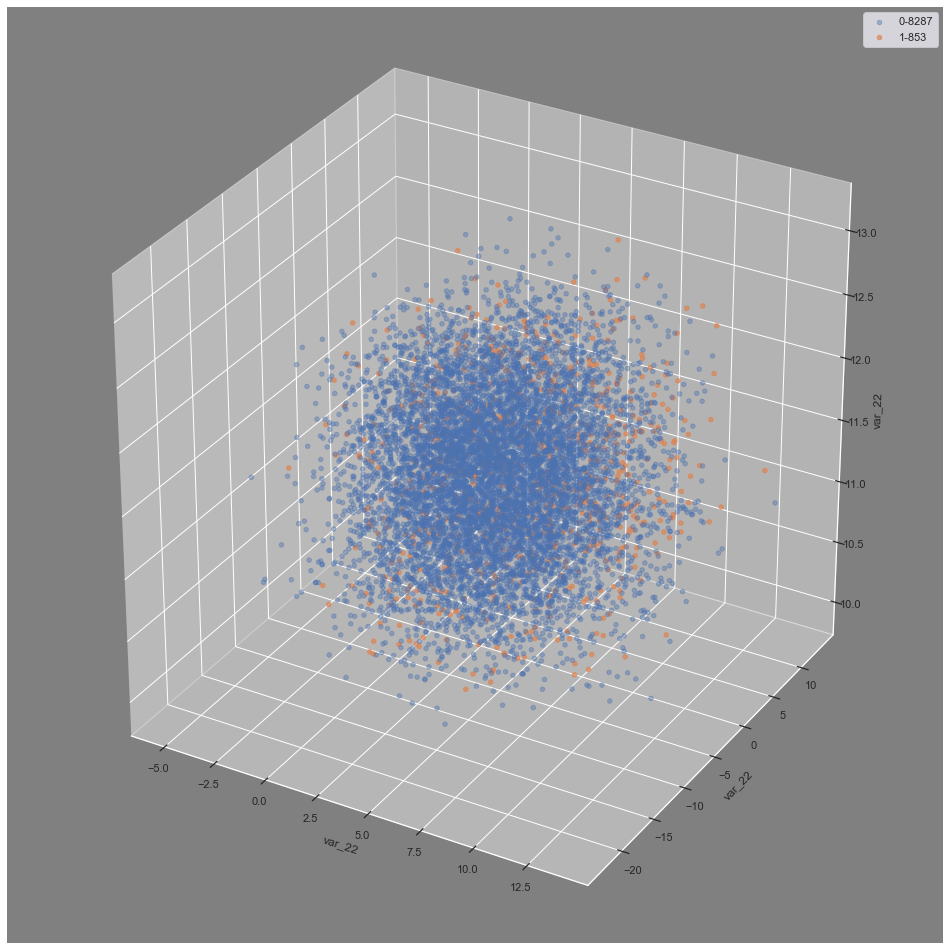

In [44]:
validation_set_pred = validation_dataset_balanced.copy()
validation_set_pred['target'] = predictions_validation

threeD_plot(validation_set_pred,['var_22','var_26','var_34'], fraq = 1.00)

### Random Forest

In [26]:
rfc = RandomForestClassifier(n_estimators = 550, max_depth = 20, min_samples_split = 20, min_samples_leaf = 6)
rfc.fit(X_train, Y_train)

RandomForestClassifier(max_depth=20, min_samples_leaf=6, min_samples_split=20,
                       n_estimators=550)

In [27]:
rf_metrics, conf_mat, predictions_validation = metrics_train_validation(rfc, X_train, Y_train, X_val, Y_val)

In [28]:
rf_metrics

{'Train': {'precision': 0.9769987174005985,
  'Accuracy': 0.8968363437328954,
  'AUC': 0.9690161534575137},
 'Validation': {'precision': 0.9236111111111112,
  'Accuracy': 0.6487964989059081,
  'AUC': 0.8237796716923198}}

In [29]:
conf_mat

Pred,0,1
True,,
0,5265,55
1,3155,665


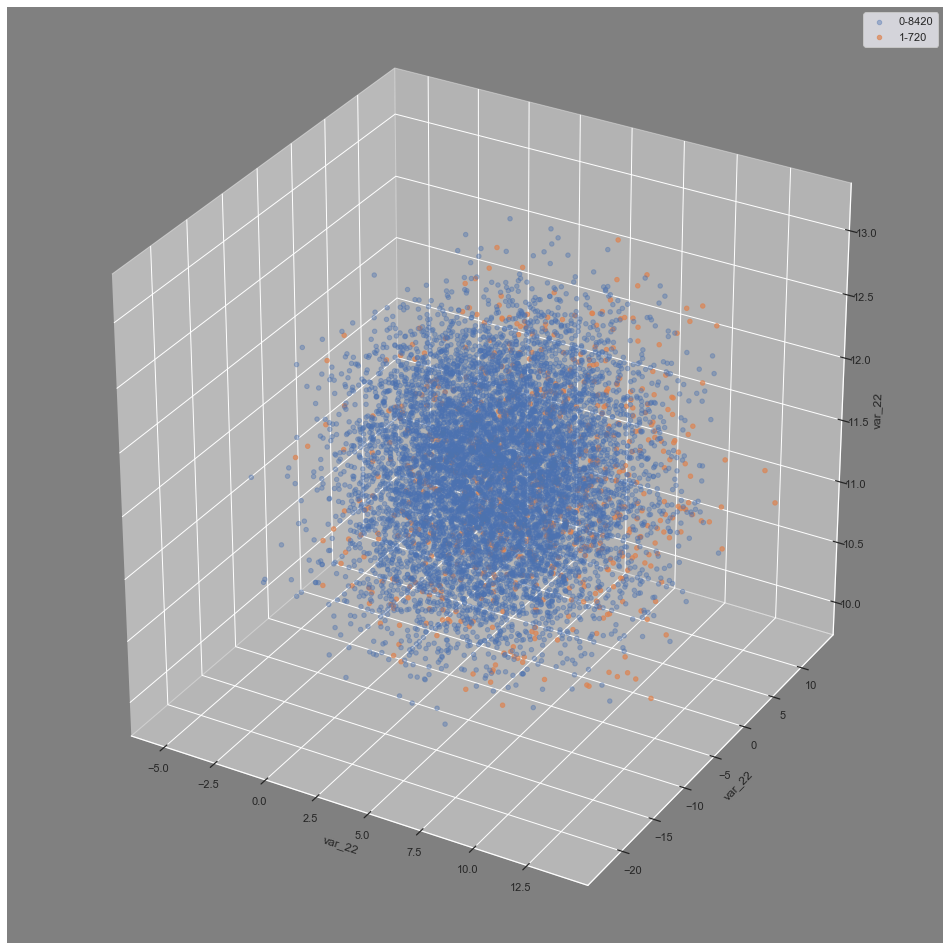

In [32]:
validation_set_pred = validation_dataset_balanced.copy()
validation_set_pred['target'] = predictions_validation

threeD_plot(validation_set_pred,['var_22','var_26','var_34'], fraq = 1.00)

### Light Gradient Boosting Machine

In [34]:
gbc = GradientBoostingClassifier(n_estimators=250, learning_rate=1.0, max_depth=10, min_samples_leaf = 20)
gbc.fit(X_train, Y_train)

GradientBoostingClassifier(learning_rate=1.0, max_depth=10, min_samples_leaf=20,
                           n_estimators=250)

In [35]:
gbc_metrics, conf_mat, predictions_validation = metrics_train_validation(gbc, X_train, Y_train, X_val, Y_val)

In [36]:
gbc_metrics

{'Train': {'precision': 0.9993201903467029,
  'Accuracy': 0.9998357963875205,
  'AUC': 0.999754102444506},
 'Validation': {'precision': 0.8982820976491862,
  'Accuracy': 0.774835886214442,
  'AUC': 0.8222378508443884}}

In [37]:
conf_mat

Pred,0,1
True,,
0,5095,225
1,1833,1987


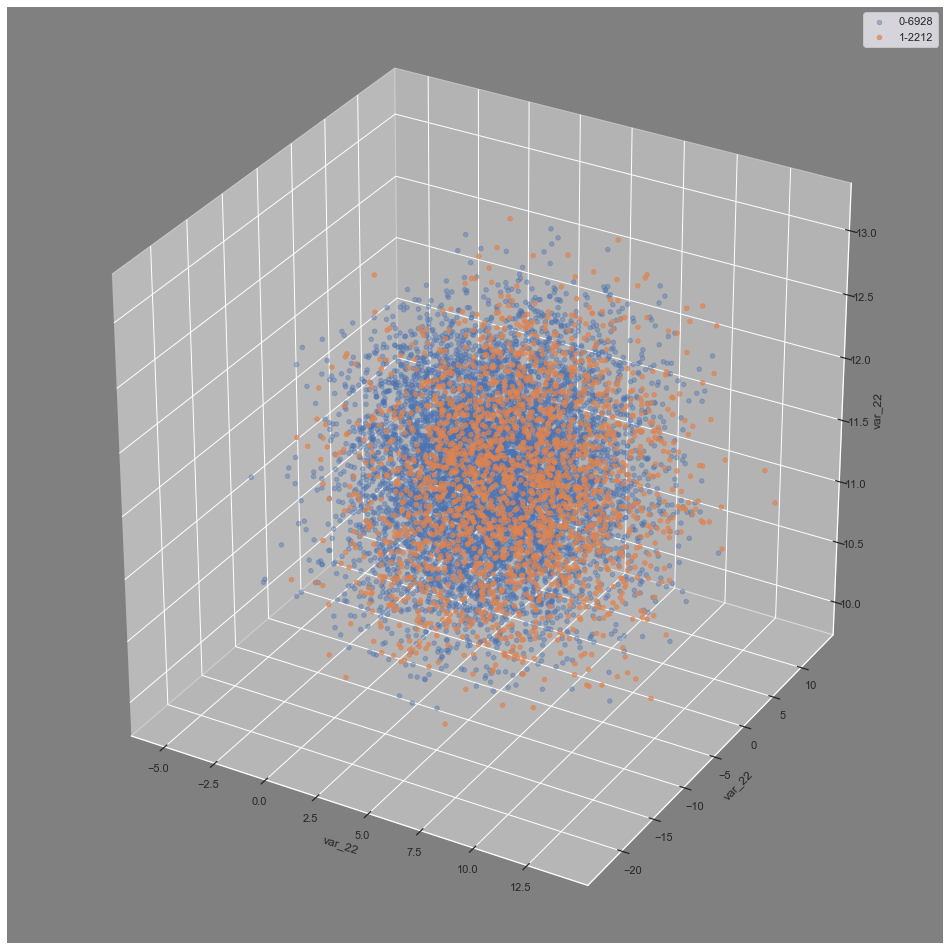

In [38]:
validation_set_pred = validation_dataset_balanced.copy()
validation_set_pred['target'] = predictions_validation

threeD_plot(validation_set_pred,['var_22','var_26','var_34'], fraq = 1.00)

<b> Summary

In [51]:
typex = 'Validation'
pd.DataFrame([knn_metrics[typex],rf_metrics[typex],gbc_metrics[typex]] ,index = ['KNN','RF','LGBM'])

,precision,Accuracy,AUC
KNN,0.764361,0.631400,0.711942
RF,0.923611,0.648796,0.823780
LGBM,0.898282,0.774836,0.822238


### Conclusions

* the tested models were KNN, RandomForest and LGBM
* keep RF and LGBM
* some issues:
    + LGBM is a little bit slow
    + Tunning will be needed
    + further Feature selection and dimensionality reduction will be needed to reduce complexity
    + both models have a good AUC